#  **Importing Libraries** ⚡

> Begin by loading all the essential libraries.

In [1]:
import nltk
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import re
import string


#  **Load the Data** 📂

> Step into the journey! Load your dataset seamlessly to kickstart the analysis pipeline. 

In [2]:
# load the data
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("conll2003" , trust_remote_code=True)

# dataset structure
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


#  **Explore the Dataset** 🔍

> Gain insights into the dataset by examining its structure


In [3]:
train_dataset = dataset['train']
test_dataset = dataset['test']
validation_dataset = dataset['validation']

# sample data
print(train_dataset[0])


{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


lets see  the actual ner tags meanings

In [4]:
label_names = dataset["train"].features["ner_tags"].feature.names

# analysis and change them
sample = dataset["train"][0]
tokens = sample["tokens"]
ner_tags = [label_names[tag] for tag in sample["ner_tags"]]

# Print the tokens and their corresponding NER tags
print("Token - NER Tag")
for token, ner_tag in zip(tokens, ner_tags):
    print(f"{token} - {ner_tag}")


Token - NER Tag
EU - B-ORG
rejects - O
German - B-MISC
call - O
to - O
boycott - O
British - B-MISC
lamb - O
. - O


In [5]:
print(type(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>


#  **Preprocessing** 🛠️

> Data preprocessing is a critical step in preparing the dataset for optimal model performance.


In [6]:
def dataset_to_dataframe(dataset):
    """
    Convert a Hugging Face Dataset to pandas DataFrame.
    Preserves lists in each column as they are.
    
    Args:
        dataset: A Hugging Face Dataset object
        
    Returns:
        pandas.DataFrame: A DataFrame containing the dataset information with list features
    """
    
    # Convert to pandas DataFrame while preserving the lists
    df = pd.DataFrame({
        column: dataset[column] for column in dataset.features
    })
    
    return df


In [7]:
train_dataset = dataset_to_dataframe(train_dataset)
test_dataset = dataset_to_dataframe(test_dataset)
validation_dataset = dataset_to_dataframe(validation_dataset)

# Print the first few rows of the train dataset
train_dataset.head()

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"
3,3,"[The, European, Commission, said, on, Thursday...","[12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 3...","[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 1...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,4,"[Germany, 's, representative, to, the, Europea...","[22, 27, 21, 35, 12, 22, 22, 27, 16, 21, 22, 2...","[11, 11, 12, 13, 11, 12, 12, 11, 12, 12, 12, 1...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


In [8]:
# no need for pos tags or chunk tags so we will drop them 
train_dataset = train_dataset.drop(columns=["pos_tags", "chunk_tags","id"] , axis=1)
test_dataset = test_dataset.drop(columns=["pos_tags", "chunk_tags" ,"id"], axis=1)
validation_dataset = validation_dataset.drop(columns=["pos_tags", "chunk_tags" ,"id"], axis=1)

In [9]:
train_dataset.sample(5)

,tokens,ner_tags
13646,"[The, men, could, face, charges, carrying, up,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8400,"[TENNIS, -, EDBERG, EXTENDS, GRAND, SLAM, RUN,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0]"
1402,"[Miss, Universe, ,, Venezuela, 's, Alicia, Mac...","[7, 8, 0, 5, 0, 1, 2, 0, 0, 5, 6, 0, 0, 0, 0, ..."
3843,"[SEATTLE, 66, 61, .520, 7]","[3, 0, 0, 0, 0]"
7279,"["", Tomorrow, ...]","[0, 0, 0]"


In [11]:
def tag_distribution(df):
	from collections import Counter
	
	# Flatten the list of NER tags
	all_tags = [tag for tags in df['ner_tags'] for tag in tags]
	
	# Count the occurrences of each tag
	tag_counts = Counter(all_tags)
	
	# Convert to DataFrame
	tag_distribution_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count'])
	
	return tag_distribution_df, tag_counts

# Calculate the distribution of NER tags in the train dataset
train_tag_distribution, train_tag_counts = tag_distribution(train_dataset)

# Display the distribution DataFrame
print(train_tag_distribution)


   Tag   Count
0    3    6321
1    0  169578
2    7    3438
3    1    6600
4    2    4528
5    5    7140
6    4    3704
7    8    1155
8    6    1157


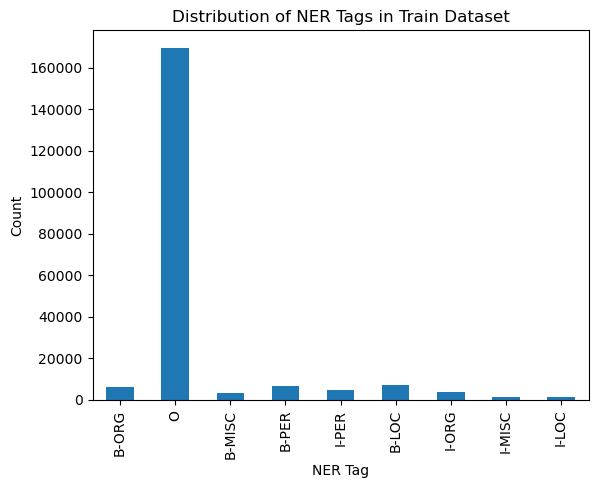

In [12]:
# Map tag indices to their corresponding names
train_tag_distribution['Tag_Name'] = train_tag_distribution['Tag'].apply(lambda x: label_names[x])

# Plot the distribution using the new Tag_Name column
train_tag_distribution.plot(x='Tag_Name', y='Count', kind='bar', legend=False)
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.title('Distribution of NER Tags in Train Dataset')
plt.show()

In [13]:
label_list = dataset["train"].features["ner_tags"].feature.names
print("Labels and their corresponding NER tags:")
for label, ner_tag in zip(label_list, ner_tags):
    print(f"{label}: {ner_tag}")


Labels and their corresponding NER tags:
O: B-ORG
B-PER: O
I-PER: B-MISC
B-ORG: O
I-ORG: O
B-LOC: O
I-LOC: B-MISC
B-MISC: O
I-MISC: O


In [14]:
train_dataset.shape

(14041, 2)

In [15]:
def drop_zero_ner_tags(df):
    return df[df['ner_tags'].apply(lambda tags: any(tag != 0 for tag in tags))]

# Apply the function to the datasets
train_dataset = drop_zero_ner_tags(train_dataset)
test_dataset = drop_zero_ner_tags(test_dataset)
validation_dataset = drop_zero_ner_tags(validation_dataset)

# Print the shape of the datasets after dropping rows
print(train_dataset.shape)
print(test_dataset.shape)
print(validation_dataset.shape)

(11132, 2)
(2756, 2)
(2605, 2)


In [16]:

from gensim.models import Word2Vec


# Extract the token sentences from the DataFrame
sentences = train_dataset['tokens'].tolist()

# Train a Word2Vec model on the token data
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert tokens to embeddings
def token_to_embedding(token):
    return word2vec_model.wv[token] if token in word2vec_model.wv else np.zeros(word2vec_model.vector_size)

# Create a feature matrix for each token in the train dataset
X_train = np.vstack([token_to_embedding(token) for sentence in train_dataset['tokens'] for token in sentence])

# Similarly, create feature matrices for the test and validation datasets
X_test = np.vstack([token_to_embedding(token) for sentence in test_dataset['tokens'] for token in sentence])
X_validation = np.vstack([token_to_embedding(token) for sentence in validation_dataset['tokens'] for token in sentence])

# Print the shape of the feature matrices
print(f"Train feature matrix shape: {X_train.shape}")
print(f"Test feature matrix shape: {X_test.shape}")
print(f"Validation feature matrix shape: {X_validation.shape}")


Train feature matrix shape: (171779, 100)
Test feature matrix shape: (39473, 100)
Validation feature matrix shape: (43478, 100)


In [17]:
# Flatten X_train
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Print the shape of the flattened X_train
print(f"Flattened X_train shape: {X_train_flattened.shape}")
# Flatten Y_train
Y_train = np.hstack(train_dataset['ner_tags'])

# Print the shape of the flattened Y_train
print(f"Flattened Y_train shape: {Y_train.shape}")

Flattened X_train shape: (171779, 100)
Flattened Y_train shape: (171779,)


#  **Random Forest Classifier** 🌟

### **Accuracy**: <span style="color:green; font-weight:bold;">89% ✅</span>

> The **Random Forest** classifier achieves excellent performance, demonstrating its ability to handle complex datasets effectively.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from tkinter import _test
from sklearn.metrics import accuracy_score, classification_report
# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train_flattened, Y_train)

# Flatten Y_test
Y_test = np.hstack(test_dataset['ner_tags'])

# Predict the NER tags for the test data
Y_test_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)
report_rf = classification_report(Y_test, Y_test_pred_rf, target_names=label_names)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("Random Forest Classification Report:")
print(report_rf)

Random Forest Accuracy: 0.8982595698325437
Random Forest Classification Report:
              precision    recall  f1-score   support

           O       0.92      1.00      0.96     31361
       B-PER       0.86      0.44      0.59      1617
       I-PER       0.61      0.20      0.30      1156
       B-ORG       0.81      0.52      0.63      1661
       I-ORG       0.70      0.47      0.57       835
       B-LOC       0.80      0.78      0.79      1668
       I-LOC       0.61      0.54      0.57       257
      B-MISC       0.80      0.67      0.73       702
      I-MISC       0.59      0.59      0.59       216

    accuracy                           0.90     39473
   macro avg       0.74      0.58      0.64     39473
weighted avg       0.89      0.90      0.88     39473



#  **Integrate the Model with a GUI** 🔗

> Connect the trained **Random Forest** model to a sleek **CustomTkinter GUI** for an intuitive and interactive experience. Enable users to input sentences and receive accurate **Named Entity Recognition (NER)** predictions in real-time.

### 🚀 Features:
- **Dynamic Input**: Users can enter text for analysis.  
- **Instant Feedback**: Real-time NER predictions displayed seamlessly.  
- **Modern Design**: Built with **CustomTkinter** for a polished and responsive interface.


In [25]:
# Function to convert predicted tag indices to their full names
def convert_tags_to_names(predicted_tags):
    tag_mapping = {
        "B-PER": "Person",
        "I-PER": "Person",
        "B-ORG": "Organization",
        "I-ORG": "Organization",
        "B-LOC": "Location",
        "I-LOC": "Location",
        "B-MISC": "Miscellaneous",
        "I-MISC": "Miscellaneous",
        "O": "O"
    }

    # Map the tags using the dictionary
    return [tag_mapping.get(tag, "Unknown") for tag in predicted_tags]


In [41]:
import customtkinter as ctk
import numpy as np

# Function to predict NER tags for the input sentence
def predict_ner():
    input_sentence = entry.get().strip()
    if not input_sentence:
        result_text.set("Please enter a valid sentence.")
        return

    tokens = input_sentence.split()
    embeddings = np.vstack([token_to_embedding(token) for token in tokens])
    embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)
    predictions = random_forest_model.predict(embeddings_flattened)
    ner_tags = [label_names[pred] for pred in predictions]
    ner_tags = convert_tags_to_names(ner_tags)
    result_text.set(f"Tokens: {tokens}\nNER Tags: {ner_tags}")

# Set up the main application window
ctk.set_appearance_mode("System")  # Options: "System", "Dark", "Light"
ctk.set_default_color_theme("green")  # Options: "blue", "dark-blue", "green"

root = ctk.CTk()
root.title("NER Tagger")
root.geometry("600x400")

# Input label
entry_label = ctk.CTkLabel(root, text="Enter a sentence:", font=("Helvetica", 20))
entry_label.pack(pady=10)

# Input field
entry = ctk.CTkEntry(root, width=500, font=("Helvetica", 14),border_color="green", border_width=2)
entry.pack(pady=10)

# Predict button
predict_button = ctk.CTkButton(root, text="Predict NER Tags", command=predict_ner, width=200)
predict_button.pack(pady=20)

# Result label
result_text = ctk.StringVar()
result_label = ctk.CTkLabel(root, textvariable=result_text, wraplength=500, font=("Helvetica", 15))
result_label.pack(pady=10)

# Footer label
footer_label = ctk.CTkLabel(
    root,
    text="Enter a sentence and click 'Predict NER Tags' to see the Named Entity Recognition results.",
    font=("Helvetica", 15),
    wraplength=500
)
footer_label.pack(pady=20)

# Run the application
root.mainloop()
